In [9]:
################################
# Solves - u'' = f             #
# With zero Dirichlet boundary #
################################
import radiant as rad
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['legend.fontsize'] = 'large'

# Problem Parameters
a = 0.
b = 1.


def exact(*x):
    return np.prod(np.sin(np.asarray(x) * 2 * np.pi / (b - a)), axis=0)


def f(*x):
    return (len(x) * (2 * np.pi / (b - a)) ** 2) * exact(*x)


def g(*x):
    return np.zeros_like(x[0])

In [10]:
# Parameters
d = 1
k = 2
levels = 12
start_delta = 10.
start_N = 3

# Computed Parameters
ranges = ((a, b),) * d
centre_thinning = 2 ** np.arange(levels)
delta_thinning = 2 ** np.arange(levels)
delta_thinning_bwc = 1.75 ** np.arange(levels)
xcs = [rad.gridinc(ranges, inc, flat=True) for inc in (b - a) / (centre_thinning * (start_N - 1))]
deltas = start_delta / delta_thinning
deltas_bwc = start_delta / delta_thinning_bwc

L = lambda func: lambda *x: - func.laplacian(*x)
B = lambda func: lambda *x: func(*x)

bndry_eps = 1e-10
Lidx = lambda cs: np.all([np.logical_and(np.abs(a - c) > bndry_eps, np.abs(b - c) > bndry_eps) for c in cs], axis=0)
Bidx = lambda cs: np.any([np.logical_or(np.abs(a - c) <= bndry_eps, np.abs(b - c) <= bndry_eps) for c in cs], axis=0)


# Integration
error_integrator = rad.integrate.QuadIntegrator(ranges)

# Solve for approximate solution
phis = [rad.Wendland(d, k, delta, xc) for delta, xc in zip(deltas, xcs)]
solver = rad.solve.MultilevelSolver(phis, rad.solve.CollocationSolver, L, Lidx, B, Bidx)

phis_bwc = [rad.Wendland(d, k, delta, xc) for delta, xc in zip(deltas_bwc, xcs)]
solver_bwc = rad.solve.MultilevelSolver(phis_bwc, rad.solve.CollocationSolver, L, Lidx, B, Bidx)


# %timeit solver.solve(f, g)
approx = solver.solve(f, g)
error = rad.error(exact, approx, error_integrator)
print("L2 Relative Error:", error)
print("Condition Number:", solver.cond())
print("Bandwidth:", solver.bandwidth())

approx_bwc = solver_bwc.solve(f, g)
error_bwc = rad.error(exact, approx_bwc, error_integrator)
print("L2 Relative Error:", error_bwc)
print("Condition Number:", solver_bwc.cond())
print("Bandwidth:", solver_bwc.bandwidth())

/home/keane/Projects/radiant/venv/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


L2 Relative Error: 0.19666923600787448
Condition Number: [35.5901480868887, 16.916220028002634, 38.530917109930705, 370.3097451230624, 1286.8636050055982, 22725.931837703505, 54092.532558369145, 13623931.464410264, 1580491.780766319, 12583687.568630807, 468580405.1652204, 438744854.9738716]
Bandwidth: [(2, 2), (4, 4), (8, 8), (16, 16), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19)]
L2 Relative Error: 0.01054177425372473
Condition Number: [35.5901480868887, 18.380474438954742, 43.79613850960128, 381.74974870555644, 5081.006019956989, 4494.216891936044, 15895.247844305672, 1633505.9397513764, 272504.3004071215, 56639827.89427252, 28312941.82322684, 61243831.83018493]
Bandwidth: [(2, 2), (4, 4), (8, 8), (16, 16), (32, 32), (38, 38), (44, 44), (50, 50), (58, 58), (66, 66), (76, 76), (86, 86)]


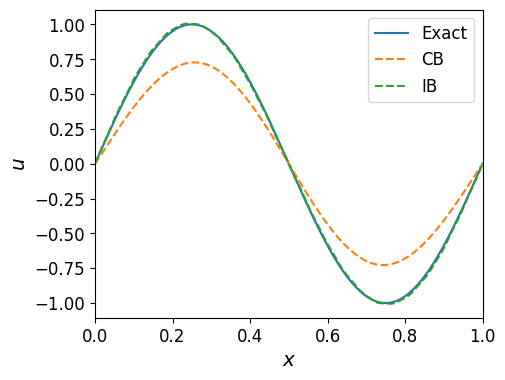

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.margins(x=0.)

x = rad.gridn(ranges, 200)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u$')
ax.plot(*x, exact(*x), label="Exact")
ax.plot(*x, approx(*x), '--', label="CB")
ax.plot(*x, approx_bwc(*x), '--', label="IB")
ax.legend()

plt.savefig("figures/multilevel/kansa/results.pdf", bbox_inches="tight")

In [12]:
idxs = range(1, levels+1)
errors = [rad.error(exact, approx[:i], error_integrator) for i in idxs]
errors_bwc = [rad.error(exact, approx_bwc[:i], error_integrator) for i in idxs]

conds = solver.cond()
conds_bwc = solver_bwc.cond()

bws = list(map(np.max, solver.bandwidth()))
bws_bwc = list(map(np.max, solver_bwc.bandwidth()))

/home/keane/Projects/radiant/venv/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


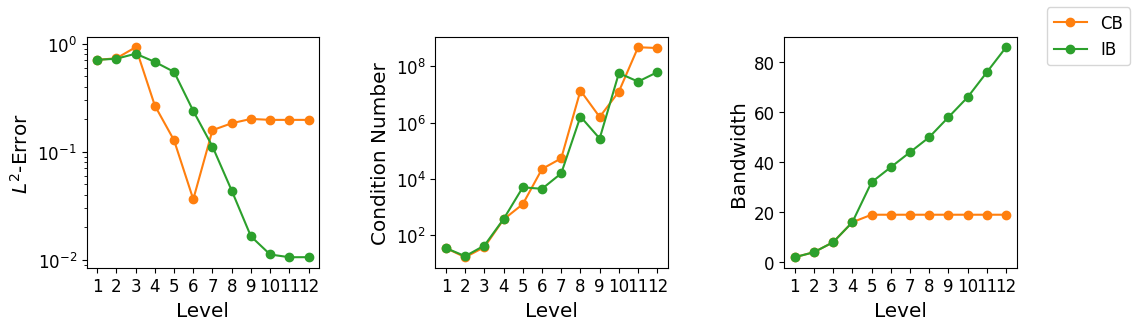

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].set_xlabel(r"Level")
axs[0].set_ylabel(r"$L^{2}$-Error")
axs[0].set_yscale('log')
axs[0].set_xticks(idxs)
axs[0].plot(idxs, errors, 'o-', color='C1', label='CB')
axs[0].plot(idxs, errors_bwc, 'o-', color='C2', label='IB')

axs[1].set_xlabel(r"Level")
axs[1].set_ylabel("Condition Number")
axs[1].set_yscale('log')
axs[1].set_xticks(idxs)
axs[1].plot(idxs, conds, 'o-', color='C1', label='CB')
axs[1].plot(idxs, conds_bwc, 'o-', color='C2', label='IB')

axs[2].set_xlabel(r"Level")
axs[2].set_ylabel("Bandwidth")
axs[2].set_xticks(idxs)
axs[2].plot(idxs, bws, 'o-', color='C1', label='CB')
axs[2].plot(idxs, bws_bwc, 'o-', color='C2', label='IB')

handles, labels = axs.flat[0].get_legend_handles_labels()
fig.legend(handles, labels)
plt.subplots_adjust(wspace=0.5)
plt.savefig("figures/multilevel/kansa/data.pdf", bbox_inches="tight")